In [1]:
import getpass
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [3]:
llm.invoke("Hello").content

'Hello! How can I assist you today?'

In [4]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [5]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./db",  
)

In [6]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import csv_loader
from langchain_community.document_loaders import TextLoader
pdf_docs_loaders = []
text_docs_loaders = []

data_directory = "./assets"
file_list = os.listdir(data_directory)
all_docs = []
for file in file_list:
    if str(file).endswith('.pdf'):
        file_path = os.path.join(data_directory, file)
        pdf_loader = PyMuPDFLoader(file_path)
        pdf_docs_loaders.append(pdf_loader.load())
    elif str(file).endswith(".txt"):
        file_path = os.path.join(data_directory, file)
        text_loader = TextLoader(file_path)
        text_docs_loaders.append(text_loader.load())

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
docs = []
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
for doc_loader in pdf_docs_loaders:
    for doc in doc_loader:
        docs.append(doc)
for doc_loaders in text_docs_loaders:
    for doc in doc_loaders:
        docs.append(doc)
docs = text_splitter.split_documents(documents = docs)

In [8]:
len(docs)

171

In [9]:
indices = vector_store.add_documents(documents = docs)

In [10]:
from langchain_core.prompts import PromptTemplate
base_model_prompt_template = PromptTemplate.from_template("""
        You are an expert in question answering regarding HDFC Life Smart Protect Plan.
        You are given a query: {query} and its relevant information for answering.
        relevant information :{similar_docs}
        Answer the query with only relevant information.
        Donot hallicunate, donot provide information beyond the context.
        Make sure the response doesn't contain personal information such as names, contact and numbers.
        Make sure not use any offensive words.
""")

In [59]:
summarizer_llm = init_chat_model("gpt-4o-mini", model_provider="openai")
summarizer_prompt = PromptTemplate.from_template("""
        You are an expert summarizer. You are given information regarding HDFC life insurance policy.
        Content : {content}
        Summarize the content such that it is helpful to reduce the context size for the language model.
        Keep the summary most informative and use less number of words.         
""")

In [168]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.checkpoint.memory import InMemorySaver
from typing import Annotated
from operator import add

class State(TypedDict):
    question: str
    context: Annotated[List[str], add]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k = 5)
    print("init length", len(state['context']))
    if(len(state['context']) >= 10):
        summ_docs = state['context'][:5]
        summary_prompt = summarizer_prompt.invoke({'content': summ_docs})
        summary = summarizer_llm.invoke(summary_prompt).content
        print(f"Summary Generated: {summary}")
        print("deleting context")
        del state['context'][0:5]
        print("appending summary")
        print("after deleting 5 and adding 1, the length is")
        state['context'].append([summary])
    docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
    print(len(state['context']))
    return {"context": [docs_content]}

def generate(state: State):
    docs_content = [doc for doc in state["context"]]
    messages = base_model_prompt_template.invoke({"query": state["question"], "similar_docs": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

checkpointer = InMemorySaver()
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}

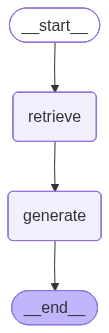

In [61]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [184]:
response = graph.invoke({"question": "What is HDFC full form?"}, config)
print(response["answer"])

init length 11
Summary Generated: The provided content includes multiple mentions of HDFC Life Insurance and its Smart Protect Plan Policy Document. Key points include:

1. **Contact Information**: For grievances, refer to Part G; dissatisfied customers may contact the Insurance Ombudsman. You can reach HDFC Life at toll-free number 1800 266 9777 or via email at onlinequery@hdfclife.in.

2. **Social Media Links**: Follow HDFC Life on YouTube, LinkedIn, Twitter, and Facebook for updates and information.

3. **Correspondence**: Always quote your policy number in future communications. For more information about products and services, consult your Certified Financial Consultant (Insurance Agent).

4. **Policy Document Details**: The policy covers proportionate risk premium and associated medical examination and stamp duty charges.

The content primarily emphasizes customer support and engagement channels, ensuring clients know how to communicate effectively with HDFC Life.
deleting contex

In [126]:
response['context'][0]

'Part E \n(Charges) \n \n1. Charges \nAll the below charges are exclusive of applicable taxes and other statutory levies, if any \n(1) Premium Allocation Charge: \nThis charge is a percentage of the Premium appropriated towards charges from the Premium received. The \nbalance amount known as allocation rate constitutes that part of Premium which is utilized to purchase the \nunits of the fund in the policy. This is a charge levied at the time of receipt of Premium. The Premium \nallocation charge is capped at 12.5% of annualized Premium in any year. \n \nPremium Allocation Charge as below will be deducted from the Premiums. The net Premiums after \ndeduction of charges are invested in Funds as per your choice. \nThe Premium allocation charge (% of AP) is as given below: \n \nPolicy Year \nAP < 2.5 lacs  \nAP >= 2.5 \nlacs \n1 \n12% \n11% \n2 \n6% \n5% \n3 \n4% \n4% \n4 \n3% \n3% \n5 year \nonwards \n0% \n0% \n \nPremium allocation charge of 2% shall be levied on top-up Premiums. \nWher

In [24]:
response = graph.invoke({"question": "Provide Premium allocation charges in table format"}, config)
print(response["answer"])

Here is the information regarding the Premium Allocation Charges for the HDFC Life Smart Protect Plan in table format:

| Policy Year         | Annualized Premium < 2.5 lacs | Annualized Premium >= 2.5 lacs |
|---------------------|-------------------------------|--------------------------------|
| 1                   | 12%                           | 11%                            |
| 2                   | 6%                            | 5%                             |
| 3                   | 4%                            | 4%                             |
| 4                   | 3%                            | 3%                             |
| 5 years onwards     | 0%                            | 0%                             |

- A premium allocation charge of 2% shall be levied on top-up premiums.
- The premium allocation charges are guaranteed for the entire duration of the policy term and shall be levied at the time of receipt of premium.


In [29]:
response = graph.invoke({"question": "Provide Premium allocation charges in table format"}, config)
print(response['answer'])

### Premium Allocation Charges for HDFC Life Smart Protect Plan

| Policy Year      | AP < 2.5 lacs | AP >= 2.5 lacs |
|------------------|---------------|----------------|
| 1                | 12%           | 11%            |
| 2                | 6%            | 5%             |
| 3                | 4%            | 4%             |
| 4                | 3%            | 3%             |
| 5 year onwards   | 0%            | 0%             |

- **Top-up Premiums**: A Premium allocation charge of 2% will be levied on top-up Premiums.
- **Capping**: The Premium allocation charge is capped at 12.5% of annualized Premium in any year.
- **Guaranteed Charges**: The Premium allocation charges are guaranteed for the entire duration of the Policy Term and shall be levied at the time of receipt of Premium.


In [65]:
for doc in graph.get_state(config):
    print(doc)

{'question': 'Provide Premium allocation charges in table format', 'context': 'Part E \n(Charges) \n \n1. Charges \nAll the below charges are exclusive of applicable taxes and other statutory levies, if any \n(1) Premium Allocation Charge: \nThis charge is a percentage of the Premium appropriated towards charges from the Premium received. The \nbalance amount known as allocation rate constitutes that part of Premium which is utilized to purchase the \nunits of the fund in the policy. This is a charge levied at the time of receipt of Premium. The Premium \nallocation charge is capped at 12.5% of annualized Premium in any year. \n \nPremium Allocation Charge as below will be deducted from the Premiums. The net Premiums after \ndeduction of charges are invested in Funds as per your choice. \nThe Premium allocation charge (% of AP) is as given below: \n \nPolicy Year \nAP < 2.5 lacs  \nAP >= 2.5 \nlacs \n1 \n12% \n11% \n2 \n6% \n5% \n3 \n4% \n4% \n4 \n3% \n3% \n5 year \nonwards \n0% \n0% \

In [42]:
len(response['context']), type(response['context'])

(44, list)